# Inversão de dados contaminados por outliers

Para avaliar a sensibilidade a outliers da abordagem clássica, será trabalhado um experimento numérico afim de investigar as seguintes questões:
1. Qual é efeito dos \textit{outliers} na inversão de parâmetros?
2. Qual é o efeito observado ao aumentar a amplitude dos \textit{outliers}?

O experimento consiste em estimar os coeficientes $\mathbf {m} = \{m_1, m_2 \}$ de uma função linear, $d^{cal} = m_1 x + m_2$, a partir de dados observados $\mathbf{d}^{obs}$ contaminado por \textit{outliers} usando a função objetivo clássica,
\begin{equation}
\phi(\mathbf{m}) = \sum_i x_i^2(\mathbf{m}).
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize

plt.style.use('seaborn-paper')

In [2]:
## função objetivo clássica
def phi(modelo, yn):
    b = modelo_linear(modelo)
    erro = yn - b    
    return 0.5*np.sum(erro**2)

Consideramos a variável independente $x$ com valores dentro do intervalo $(- 1, 1)$ para gerar $50$ números obedecendo a uma reta, representada por $d^{real}$, com coeficientes $m_1^{real} = 1 $ e $m_2^{real} = 2$. Em seguida, contaminamos os números gerados por uma distribuição gaussiana com média zero e desvio padrão $\sigma = 0,1$. Além disso, $d^{obs}$ foi contaminado com \textit{outliers} na região $0,4 < x < 0,9$. 


In [3]:
numPontos = 50          # numero de pontos
x = np.linspace(-1,1,numPontos)
outlierPorcentagem = 30 # porcentagem de contaminação por outliers
media, desvio = 0, 1e-1 # média e desvio padrão do erro gaussiano
N = 100                 # numero de observações

In [4]:
## modelo linear
def modelo_linear(modelo):
  X = np.linspace(-1,1,numPontos)
  A = np.array([X, np.ones(X.size)]).T
  x = np.array([modelo[0], modelo[1]])
  return np.dot(A, x)

In [5]:
## dado observado sem outlier
d = modelo_linear([1,2])

## dado observado com outliers
dg = d + np.random.normal(media, desvio, d.shape) # ruido gaussiano

Na simulação, os \textit{outliers} adicionados em cada medida obedecem a relação

\begin{equation}
    d^{obs}_i \rightarrow d^{real}_i + \gamma g \mu^{real}, \quad g\in(0,\,1)
\end{equation}

isto é, a contaminação se deu adicionando ao valor real da posição $i$ uma quantidade aleatória. Nesta equação, $\mu^{real}$ representa o valor médio de $d^{real}$, $g\in(0,1)$ assume valores aleatórios e $\gamma$ é um fator que permite controlar a amplitude dos \textit{outliers}. Para responder a questão 1, foi fixado $\gamma = 10$, enquanto para responder a questão 2 o experimento foi repetido com $5 \le \gamma \le 1000$ com passos de $5$ unidades. 

In [6]:
### adicionar picos

mu = d.mean()

def dobs(d_obs, gamma, media):
  dobs = d_obs.copy()
  for p in range(35,45):
    dobs[p] = dobs[p] + gamma*np.random.random()*mu
  return dobs

In [7]:
## Dado observado para o experimento 1
dexp1 = dobs(dg, 10, mu)

In [8]:
res = minimize(phi, x0=[0,0], args=(dexp1), method='CG', tol=1e-6)
dcalExp1 = modelo_linear(res.x)

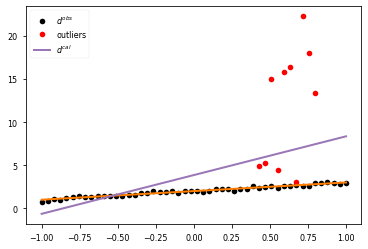

In [9]:
fig, ax = plt.subplots()
ax.plot(x, dg, 'o', c='black', label=r'$d^{obs}$')
ax.plot(x[35:45], dexp1[35:45], 'o', c='red', label='outliers')
ax.plot(x, modelo_linear([1,2]), color='#FF7E00', lw=2)
ax.plot(x, dcalExp1, label=r'$d^{cal}$', color='#9a76b6', lw=2)
ax.legend()

In [10]:
mcal = {}

for gamma in np.arange(0,1005,5):

  do = dobs(dg, gamma, mu)

  res = minimize(phi, x0=[0,0], args=(do), method='CG', tol=1e-6)
  mcal[str(gamma)] = res

Para avaliar os resultados, consideramos o desvio absoluto computado entre o valor calculado e o valor real dos coeficientes da reta: $|\Delta m_1| = |m_1 - m_1^{real}|$ e $|\Delta m_1| = |m_1 - m_1^{real}|$. Neste sentido, um bom resultado ocorre quando estes desvios se aproxima de 0 (os parâmetros são idênticos) e o contrário quando se afastam (o parâmetro calculado não representa o real). 

In [11]:
a, b = [], []
for _ in mcal.keys():
  a.append(abs(1 - mcal[_].x[0])), b.append(abs(2 - mcal[_].x[1]))

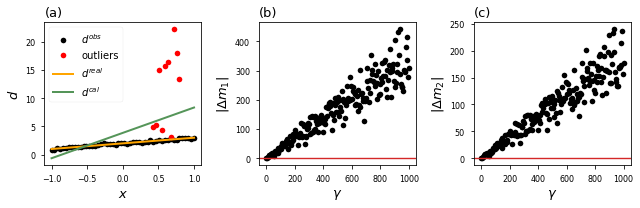

In [12]:
fig,ax = plt.subplots(1,3, figsize=(9,3), tight_layout=True)

## experimento 1:
ax[0].plot(x, dg, 'o', color='k', label='$d^{obs}$')
ax[0].plot(x[35:45], dexp1[35:45], 'o', color='red', label='outliers')
ax[0].plot(x, d, color='orange', lw=2, label=r'$d^{real}$')
ax[0].plot(x, dcalExp1, color='#559559', lw=2, label=r'$d^{cal}$')

## Experimento 2
ax[1].plot(np.arange(0,1005,5), a, 'o', c='k')
ax[1].axhline(0, color='#d42828')

ax[2].plot(np.arange(0,1005,5), b, 'o', c='k')
ax[2].axhline(0, color='#d42828')

ax[1].set_ylabel(r'$|\Delta m_1|$', fontsize=13)
ax[2].set_ylabel(r'$|\Delta m_2|$', fontsize=13)

for _, lab in zip(range(3), ['(a)', '(b)', '(c)']):
  ax[_].set_xlabel(r'$\gamma$', fontsize=13)
  ax[_].set_title(lab, loc='left', fontsize=13)

ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$d$', fontsize=13)
ax[0].legend(fontsize=10)

#fig.savefig(mydrive+'/retaL2_parametrosEstimados.pdf')

A figura anterior apresenta os resultados deste teste. Em (a) percebemos que a reta calculada sofre forte influência dos \textit{outliers}, inclinando-se ao encontro desses e em (b) e (c) identificamos que na medida em que a amplitude dos \textit{outliers} aumenta, os resultados vão ficando cada vez mais distante do real.  

Assim, o experimento demonstra que usar a abordagem clássica do problema inverso para estimar parâmetros não é uma boa estratégia neste tipo de problema. Nesse sentido, se faz necessário a busca por novas abordagens estatísticas para lidar com problemas que envolvem \textit{outliers}.